<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/01_CheckGatheredData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import numpy as np
import pickle

In [ ]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

**Read the csv files**


*   Define correct seperator, tab in our example
*   Use dtype to enforce data type mainy in casefield field has mix data types
*   Use low_memory=False so you do not mind whatever type the undefined fields are read in they have mix data





In [ ]:
path = "/content/drive/MyDrive/ColabNotebooks/dataset/01_GatheredData/"

In [ ]:
#file = '2022Sales'
#file = '2021Sales'
#file = '2020Sales'
#file = '2019Sales'
file = '20161718Sales'

In [ ]:
data = pd.read_csv(path + file + '.csv', sep='\t', lineterminator='\r', low_memory=False) # , dtype={"DATE1": 'string', "SLS_CNTR_ID": "string", "ITEM_ID": "string"}

Review data structure and scheme

In [ ]:
print("number of records:", len(data))
print("data shape:", data.shape) # shape = rows x colums
print(data.head(5)) # print first 5 rows
print(data.tail(5)) # print last 5 rows
print("*** data scheme ***")
print(data.info())  # data scheme

Drop / filter out rows in the dataframe with column ITEM_ID values NA/NAN

In [ ]:
cols_to_keep = ['DATE1','SLS_CNTR_ID', 'ITEM_ID', 'QTY', 'TTL_VAL', 'TTL_CST']
# data = data.loc[:, cols_to_keep]
data = data[cols_to_keep]
data = data.reset_index()
data.head()

,index,DATE1,SLS_CNTR_ID,ITEM_ID,QTY,TTL_VAL,TTL_CST
0,0,2018-02-02 00:00:00.000,7.0,9391,1.0,25.0,18.75
1,1,2018-02-06 00:00:00.000,7.0,9391,1.0,25.0,18.75
2,2,2018-04-07 00:00:00.000,7.0,10395,1.0,80.0,60.00
3,3,2018-04-13 00:00:00.000,7.0,10395,1.0,80.0,60.00
4,4,2018-04-17 00:00:00.000,7.0,9391,1.0,25.0,18.75


In [ ]:
# Drop rows that has NaN values on selected columns
data = data.dropna(subset=['DATE1','SLS_CNTR_ID', 'ITEM_ID', 'TTL_VAL', 'TTL_CST']) 
# data = data[data['ITEM_ID'].notnull()] # data.head(-1) # will hide last 1 row only
#True

Replace NAN by 0, if something else required then check it case by case

In [ ]:
# replace NAN with 0
# If some fields are enforced to be string type, will get error: Cannot set non-string value '0' into a StringArray.
data.replace(np.nan, 0)
True

True

Select the features required from tha data scheme and Convert required fields to the required format

In [ ]:
data['DATE1'] = pd.to_datetime(data['DATE1'], format='%Y-%m-%d %H:%M:%S') # format used in the file: '2022-01-01 0:00:00'
data['DATE1'].dt.date # remove time from date
# SLS_CNTER_ID may be read as float, so we need to confirm it is read as integer
data['SLS_CNTR_ID'] = data['SLS_CNTR_ID'].fillna(0).astype(int)
# ITEM_ID is mix of strings and numbers, so same ID (for example 95) could be read as integer and as text,
# which yields to 2 indexed rather than one, so we convert everything to string
data['ITEM_ID'] = data['ITEM_ID'].astype(str)
True

True

In [ ]:
# Aggregate to avoid duplicate entry issue
df = data.groupby(['ITEM_ID', 'SLS_CNTR_ID', 'DATE1']).agg({'QTY': "sum", "TTL_VAL":"sum", "TTL_CST":"sum"})
df.sort_index(inplace=True)
df = df.reset_index()
df.head()
True

True

Test some data to ensure everything is read correctly

In [ ]:
df.loc[pd.IndexSlice[:,13],:]

In [ ]:
df.loc[('95',4)]

In [ ]:
df.loc[('95',4),:].QTY.sum()

In [ ]:
df.loc[('95',4)].sum()

In [ ]:
df[df.index.get_level_values('ITEM_ID').isin(['95', 95]) & df.index.get_level_values('SLS_CNTR_ID').isin([4, '4'])].QTY.sum()

In [ ]:
# level 0 is the first index, in our case it is ITEM_ID
x = df[df.index.isin(['95', 'z94'], level='ITEM_ID')]  # Filter dataframe where ITEM_ID is either 95 or z94
# x = df[df.index.isin(['95', 'z94'], level=0)]  # level can be defined by either string or index int
y = df[~df.index.isin(['95', 'z94'], level=0)] # Filter dataframe where ITEM_ID is neither 95 nor z94
print(len(x), " + ", len(y), " = ", len(df))

Save to pickle

In [ ]:
with open(path + file + '.pk', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
df

,ITEM_ID,SLS_CNTR_ID,DATE1,QTY,TTL_VAL,TTL_CST
0,000011,1,2017-09-14,1.0,75.0,56.25
1,000011,1,2018-02-16,2.0,150.0,112.50
2,000011,1,2018-02-22,2.0,150.0,112.50
3,000011,1,2018-02-23,4.0,300.0,225.00
4,000011,1,2018-03-01,3.0,225.0,180.00
...,...,...,...,...,...,...
1252033,z99,18,2018-12-26,3.0,60.0,51.00
1252034,z99,18,2018-12-27,2.0,40.0,34.00
1252035,z99,18,2018-12-30,5.0,100.0,85.00
1252036,z99,18,2018-12-31,3.0,60.0,51.00


Build pivot table

In [ ]:
mask = df[(df.index.isin(['95', 'z94'], level=0)) & 
          ((df.index.get_level_values('DATE1').dayofweek == 4) | (df.index.get_level_values('DATE1').dayofweek == 5)
          )] # Monday=0, Sunday=6
#mask = df[~df.index.get_level_values('ITEM_ID').isin(['95', 'z94'])]

In [ ]:
table = mask.pivot_table(
        values='QTY', 
        index=['ITEM_ID'],
       # columns=['SLS_CNTR_ID'],
       columns=['DATE1'], 
        aggfunc='sum', 
    )
# replace NAN with 0
table = table.replace(np.nan, 0)
table

# Numbers format can be done also as:
#with pd.option_context('display.float_format', '#{:0.2f}'.format):
#  print(table)

DATE1,2016-03-05,2016-04-23,2016-04-29,2016-04-30,2016-05-06,2016-05-07,2016-05-13,2016-05-14,2016-05-21,2017-09-29,...,2018-11-30,2018-12-01,2018-12-07,2018-12-08,2018-12-14,2018-12-15,2018-12-21,2018-12-22,2018-12-28,2018-12-29
ITEM_ID,,,,,,,,,,,,,,,,,,,,,
95,2.0,1.0,3.0,6.0,1.0,4.0,5.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,69.0
z94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,11.0,8.0,8.0,5.0,9.0,4.0,4.0,8.0,13.0


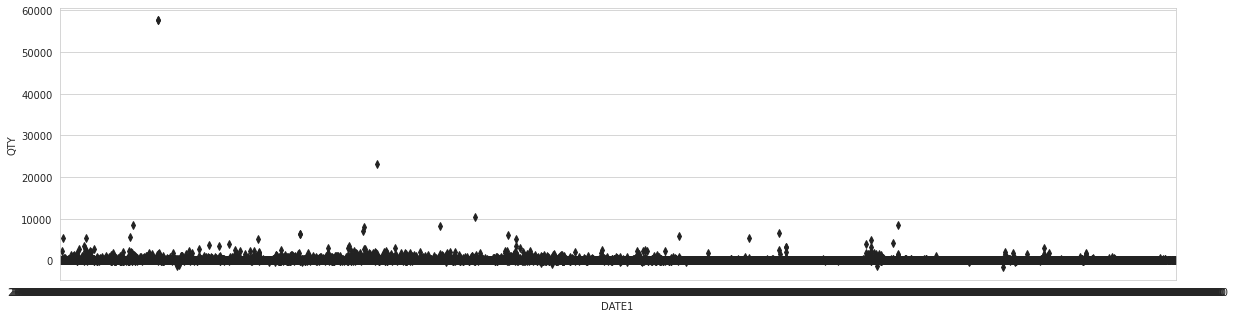

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [20, 5] #  [width, height]  
sns.boxplot(x = df.index.get_level_values('DATE1'),  # ('SLS_CNTR_ID')
            y = 'QTY',
            data = df, palette="Blues", width=0.3)

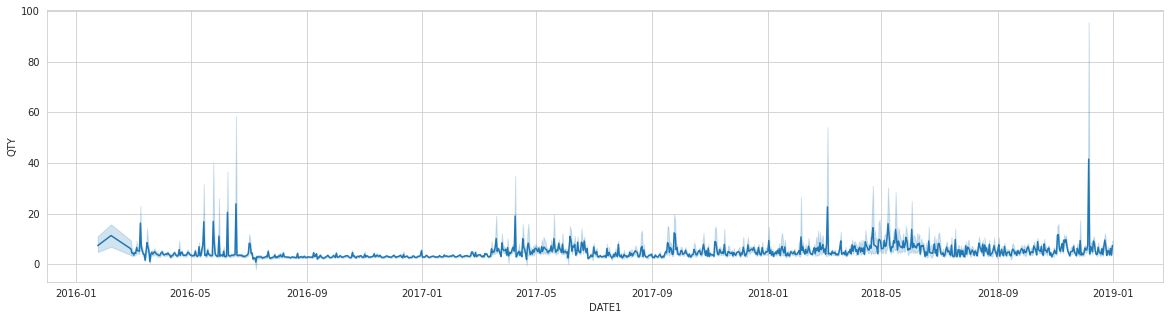

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [20, 5] #  [width, height]  
sns.lineplot(x = df.index.get_level_values('DATE1'),  # ('SLS_CNTR_ID')
            y = 'QTY',
            data = df)

In [ ]:
#mask = df[df.index.get_level_values('ITEM_ID').isin(['95', 'z94'])]
mask = df
ax = mask.unstack(level='SLS_CNTR_ID').plot(kind='bar', subplots=True, rot=0, figsize=(18, 4), layout=(5, 9))
plt.tight_layout()

ValueError: ignored

<Figure size 1296x288 with 0 Axes>